In [1]:
from models.UNet import *

import matplotlib.pyplot as plt
import numpy as np
import os
import time

Using TensorFlow backend.


# Load Data

In [2]:
x_train = np.load('./dataset/x_train.npy')
y_train = np.load('./dataset/y_train.npy')
x_test = np.load('./dataset/x_test.npy')
y_test = np.load('./dataset/y_test.npy')

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(213, 64, 64, 1) (213, 64, 64, 1)
(54, 64, 64, 1) (54, 64, 64, 1)


# Segmentation Class U-Net

In [3]:
seg_model = UNet(img_shape = x_train[0].shape, num_of_class = 1,learning_rate = 2e-4, do_drop = True, drop_rate = 0.5)

In [4]:
seg_model.show_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

# Train Model

In [5]:
history = seg_model.train(x_train, y_train, epoch = 100, batch_size = 64)

Train on 170 samples, validate on 43 samples
Epoch 1/100
170/170 [==============================] - 18s 104ms/step - loss: 0.6362 - dice_coef: 0.2977 - val_loss: 0.5813 - val_dice_coef: 0.2477
Epoch 2/100
170/170 [==============================] - 1s 5ms/step - loss: 0.5644 - dice_coef: 0.2608 - val_loss: 0.5101 - val_dice_coef: 0.2575
Epoch 3/100
170/170 [==============================] - 1s 5ms/step - loss: 0.4819 - dice_coef: 0.2886 - val_loss: 0.4182 - val_dice_coef: 0.3495
Epoch 4/100
170/170 [==============================] - 1s 5ms/step - loss: 0.3866 - dice_coef: 0.3961 - val_loss: 0.3287 - val_dice_coef: 0.4904
Epoch 5/100
170/170 [==============================] - 1s 5ms/step - loss: 0.3542 - dice_coef: 0.5013 - val_loss: 0.3082 - val_dice_coef: 0.5041
Epoch 6/100
170/170 [==============================] - 1s 4ms/step - loss: 0.3273 - dice_coef: 0.4939 - val_loss: 0.2880 - val_dice_coef: 0.5382
Epoch 7/100
170/170 [==============================] - 1s 4ms/step - loss: 0.2904 

Epoch 57/100
170/170 [==============================] - 1s 5ms/step - loss: 0.0393 - dice_coef: 0.9523 - val_loss: 0.0650 - val_dice_coef: 0.9402
Epoch 58/100
170/170 [==============================] - 1s 5ms/step - loss: 0.0398 - dice_coef: 0.9527 - val_loss: 0.0708 - val_dice_coef: 0.9406
Epoch 59/100
170/170 [==============================] - 1s 5ms/step - loss: 0.0398 - dice_coef: 0.9531 - val_loss: 0.0656 - val_dice_coef: 0.9442
Epoch 60/100
170/170 [==============================] - 1s 5ms/step - loss: 0.0392 - dice_coef: 0.9547 - val_loss: 0.0645 - val_dice_coef: 0.9440
Epoch 61/100
170/170 [==============================] - 1s 5ms/step - loss: 0.0379 - dice_coef: 0.9548 - val_loss: 0.0628 - val_dice_coef: 0.9445
Epoch 62/100
170/170 [==============================] - 1s 5ms/step - loss: 0.0374 - dice_coef: 0.9538 - val_loss: 0.0658 - val_dice_coef: 0.9477
Epoch 63/100
170/170 [==============================] - 1s 5ms/step - loss: 0.0394 - dice_coef: 0.9563 - val_loss: 0.0654 - 

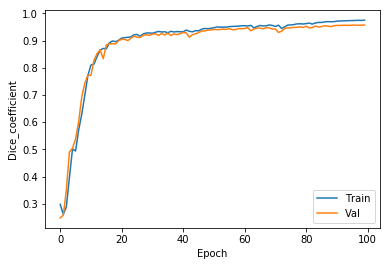

In [6]:
plot_dice(history)

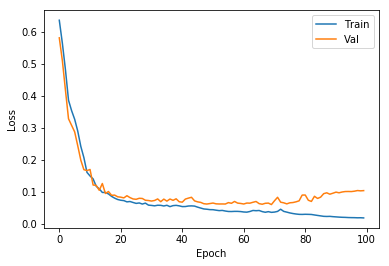

In [7]:
plot_loss(history)

# Show result

In [8]:
preds = seg_model.predict(x_test)

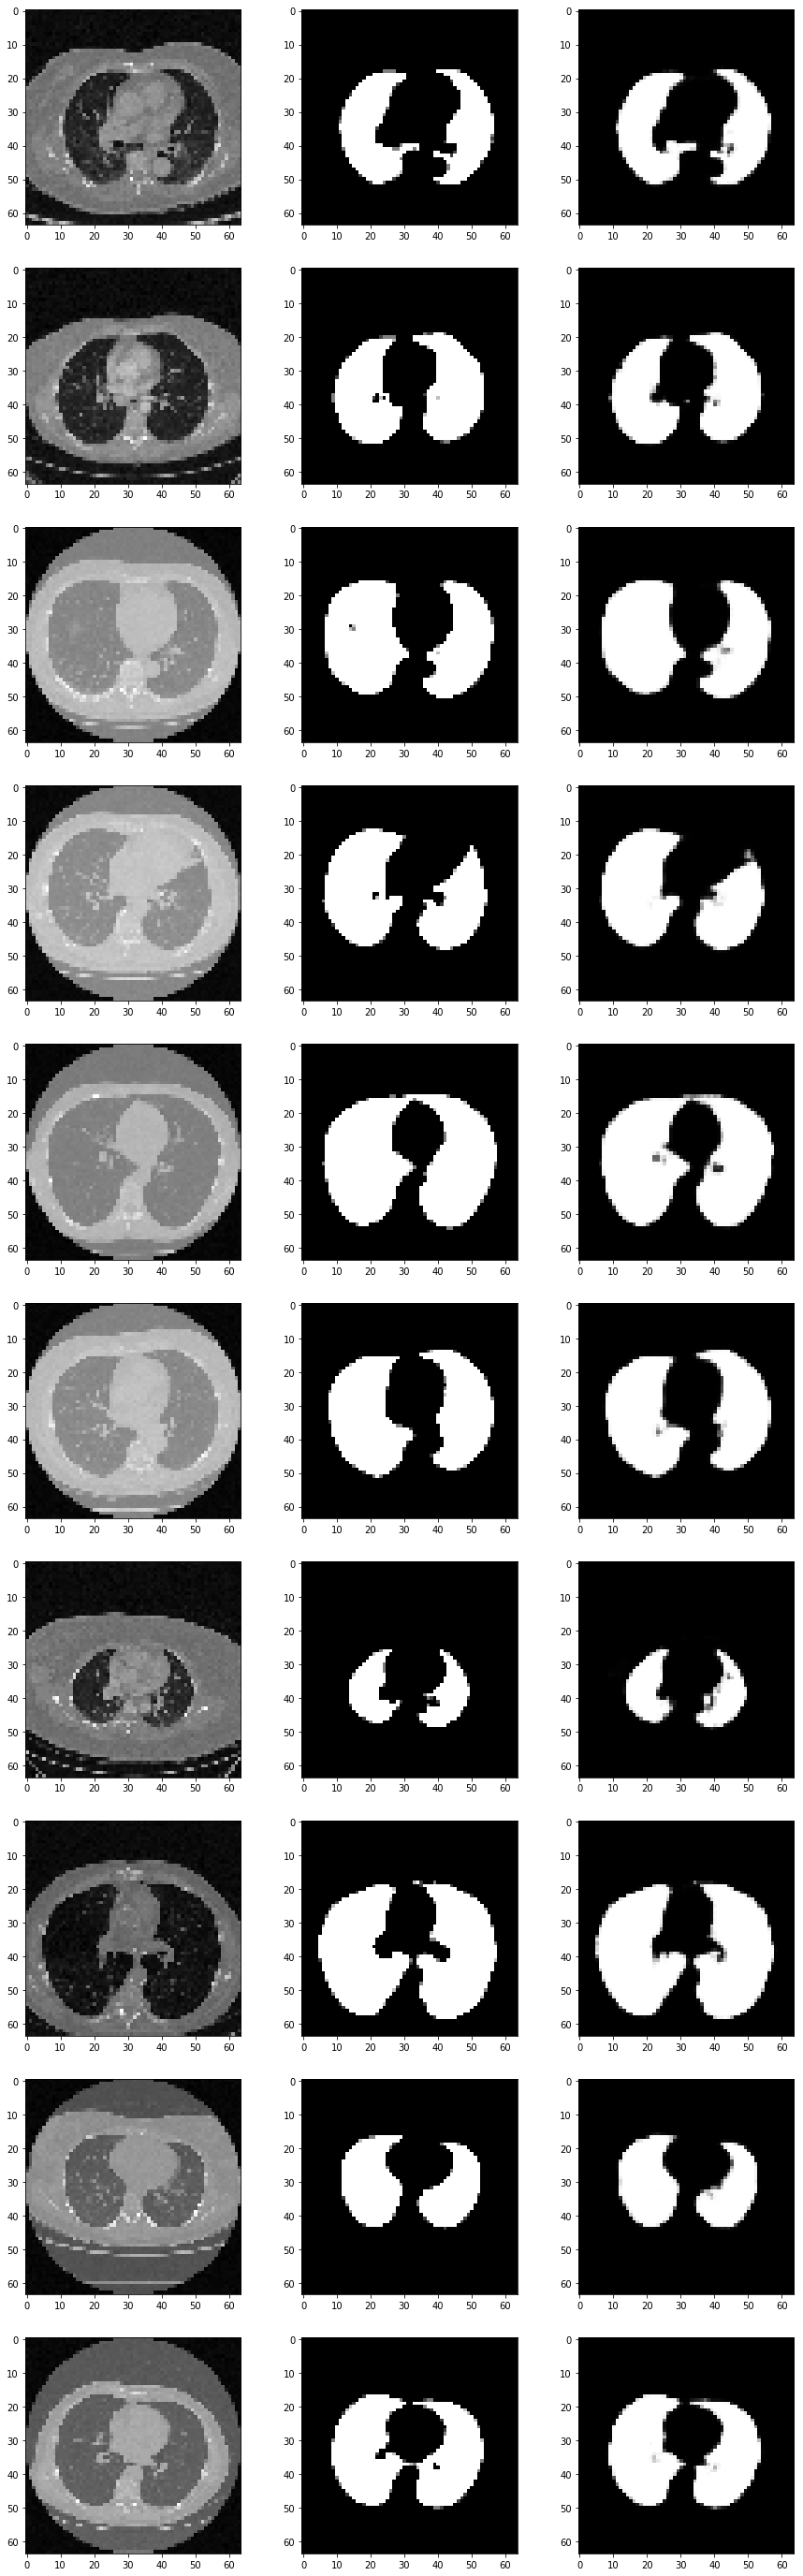

In [9]:
show_num = 10
fig, ax = plt.subplots(show_num, 3, figsize=(15, 50))

for i, pred in enumerate(preds[:show_num]):
    ax[i, 0].imshow(x_test[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_test[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')